# Visualization of the Pb boundary conditions based on transects

In [23]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cmocean
from math import sin, cos, sqrt, atan2, radians
import xarray as xr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

%matplotlib inline

#### Parameters

In [24]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1598,2177,778,798) # Northern Canada Basin 
bdy_WCB = (2168,2178,390,797) # Western Canada Basin 
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,293,303) # Hudson Bay

In [25]:
# Colors
land_color = '#a9a7a2'
color_sBB  = '#cc0e1d'
color_sGR  = '#ffb7aa'
light_gray = '#b1b1b1'
light_land = '#d0d0cf'
land_edge  = '#929291'

#### Files

In [26]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [39]:
mesh        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_hdept  = mesh['hdept'].values[0,:,:]
mesh_hdepw  = mesh['hdepw'].values[0,:,:]
mesh_mbathy = mesh['mbathy'].values[0,:,:]
mesh_e3tps  = mesh['e3t_ps'].values[0,:,:]
mesh_e3t    = mesh['e3t_0'].values[0,:,:]
e3t_masked = np.ma.masked_where((mesh_bathy< 0.1), mesh_e3t)

In [40]:
gdepw1d = mesh['gdepw_1d'].values[0,:]
gdept1d = mesh['gdept_1d'].values[0,:]

Boundary Condition file:

In [29]:
# Labrador Sea
dPb_S_lons = mesh_lon[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]] 
dPb_S_lats = mesh_lat[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
dPb_S_mdepths = bathy_masked[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]

# Northern Canada Basin
dPb_E_lons = mesh_lon[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_E_lats = mesh_lat[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_E_mdepths = bathy_masked[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 

# Western Canada Basin
dPb_N_lons = mesh_lon[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]] 
dPb_N_lats = mesh_lat[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]
dPb_N_mdepths = bathy_masked[:,bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]

# Hudson Bay
dPb_W_lons = mesh_lon[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_W_lats = mesh_lat[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_W_mdepths = bathy_masked[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 

In [30]:
# model results:
results_folder = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-reference-2015_20230308/'

file  = nc.Dataset(f'{results_folder}ANHA12_EXH006_1m_20150101_20151231_comp_201508-201508.nc','r')
dPb_S = np.array(file.variables['dissolpb'])[0,:,bdy_LS[0]-imin:bdy_LS[1]-imin,bdy_LS[2]-jmin:bdy_LS[3]-jmin]
dPb_N = np.array(file.variables['dissolpb'])[0,:,bdy_WCB[0]-imin:bdy_WCB[1]-imin,bdy_WCB[2]-jmin:bdy_WCB[3]-jmin] 
dPb_E = np.array(file.variables['dissolpb'])[0,:,bdy_NCB[0]-imin:bdy_NCB[1]-imin,bdy_NCB[2]-jmin:bdy_NCB[3]-jmin] 
dPb_W = np.array(file.variables['dissolpb'])[0,:,bdy_HB[0]-imin:bdy_HB[1]-imin,bdy_HB[2]-jmin:bdy_HB[3]-jmin]

#### Functions

In [31]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [32]:
def plot_transect(ax, variable, vrange=(30,35), label='', cmap=cmocean.cm.deep, labelling=True):
    
    ax.invert_yaxis()
    ax.set_ylim(4000, -60)
    ax.set_xlim(0, 1100)
    ax.tick_params(axis='both', which='major', labelsize=6)
    
    # plot model boundary condition:
    bdy_cell = 0
    xx, zz = np.meshgrid(S_distance, depths)
    CB1 = ax.pcolormesh(xx, zz, variable[:,bdy_cell,:], vmin=vrange[0], vmax=vrange[1], cmap=cmap)
    ax.pcolormesh(xx, zz, dPb_S_mdepths[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]))

    if labelling:
        ax.set_xlabel('Distance [km]', fontsize=7)
        ax.set_ylabel('Depth [m]', fontsize=7)

        axins = inset_axes(ax, width="5%", height="45%", loc='lower left', borderpad=1)

        CBar   = plt.colorbar(CB1, ax=ax, cax=axins); 
        CBar.set_label(f'{label}', fontsize=7)
        CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return CB1

In [42]:
def get_boundary_depths(bdy_distance, bdy_ind, cell=0):
    
    model_depths    = np.zeros((len(depths), len(bdy_distance)))
    model_distances = np.zeros((len(depths), len(bdy_distance)))

    for n in range(0,len(bdy_distance)): #bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]
        mesh_depth_adjusted = np.copy(gdepw1d)
        if (bdy_ind[1]-bdy_ind[0]) < (bdy_ind[3]-bdy_ind[2]): # depending on orientation of boundary
            bathy_ind           = mesh_mbathy[bdy_ind[0]+cell, bdy_ind[2]+n]
            mesh_depth_adjusted[0:int(bathy_ind)]  = mesh_hdepw[bdy_ind[0]+cell, bdy_ind[2]+n]
        else:
            bathy_ind           = mesh_mbathy[bdy_ind[0]+n, bdy_ind[2]+cell]
            mesh_depth_adjusted[0:int(bathy_ind)]  = mesh_hdepw[bdy_ind[0]+n, bdy_ind[2]+cell]

        model_depths[:,n]    = mesh_depth_adjusted
        model_distances[:,n] = bdy_distance[n]
    
    return model_depths, model_distances

In [34]:
def land_patch(distances, coordi, coordj, EW=True):
    
    topo = []
    for d, distance in enumerate(distances[0:-1]):
        if EW: # east-west
            rect = Rectangle((distance, mesh_hdepw[coordi,coordj+d]), distances[d+1]-distance, 5000)
        else:
            rect = Rectangle((distance, mesh_hdepw[coordi+d,coordj]), distances[d+1]-distance, 5000)
        topo.append(rect)

    pc = PatchCollection(topo, facecolors=land_color, edgecolors=land_color, alpha=1)
    return pc

#### Calculations

In [127]:
bdy_cell=9

In [128]:
# Look at only one slice of the rimwidth thickness boundary:
S_distance  = calc_distance(dPb_S_lats[bdy_cell,:]  , dPb_S_lons[bdy_cell,:])    # Labrador Sea
N_distance  = calc_distance(dPb_N_lats[bdy_cell-1,:], dPb_N_lons[bdy_cell,:])    # western CB
E_distance  = calc_distance(dPb_E_lats[:,bdy_cell-1], dPb_E_lons[:,bdy_cell]) # northern CB
W_distance  = calc_distance(dPb_W_lats[:,bdy_cell], dPb_W_lons[:,bdy_cell]) # Hudson Bay

In [129]:
S_model_depths, S_model_distances = get_boundary_depths(S_distance, bdy_LS,  cell=bdy_cell)
N_model_depths, N_model_distances = get_boundary_depths(N_distance, bdy_WCB, cell=bdy_cell)
E_model_depths, E_model_distances = get_boundary_depths(E_distance, bdy_NCB, cell=bdy_cell)
W_model_depths, W_model_distances = get_boundary_depths(W_distance, bdy_HB,  cell=bdy_cell)

In [130]:
LS_patch = land_patch(S_distance, bdy_LS[0]+bdy_cell, bdy_LS[2], EW=True)
N_patch  = land_patch(N_distance, bdy_WCB[0]+bdy_cell, bdy_WCB[2], EW=True)
E_patch  = land_patch(E_distance[::-1], bdy_NCB[0], bdy_NCB[3]-bdy_cell, EW=False)
W_patch  = land_patch(W_distance, bdy_HB[0], bdy_HB[2]+bdy_cell, EW=False)

#### Figures

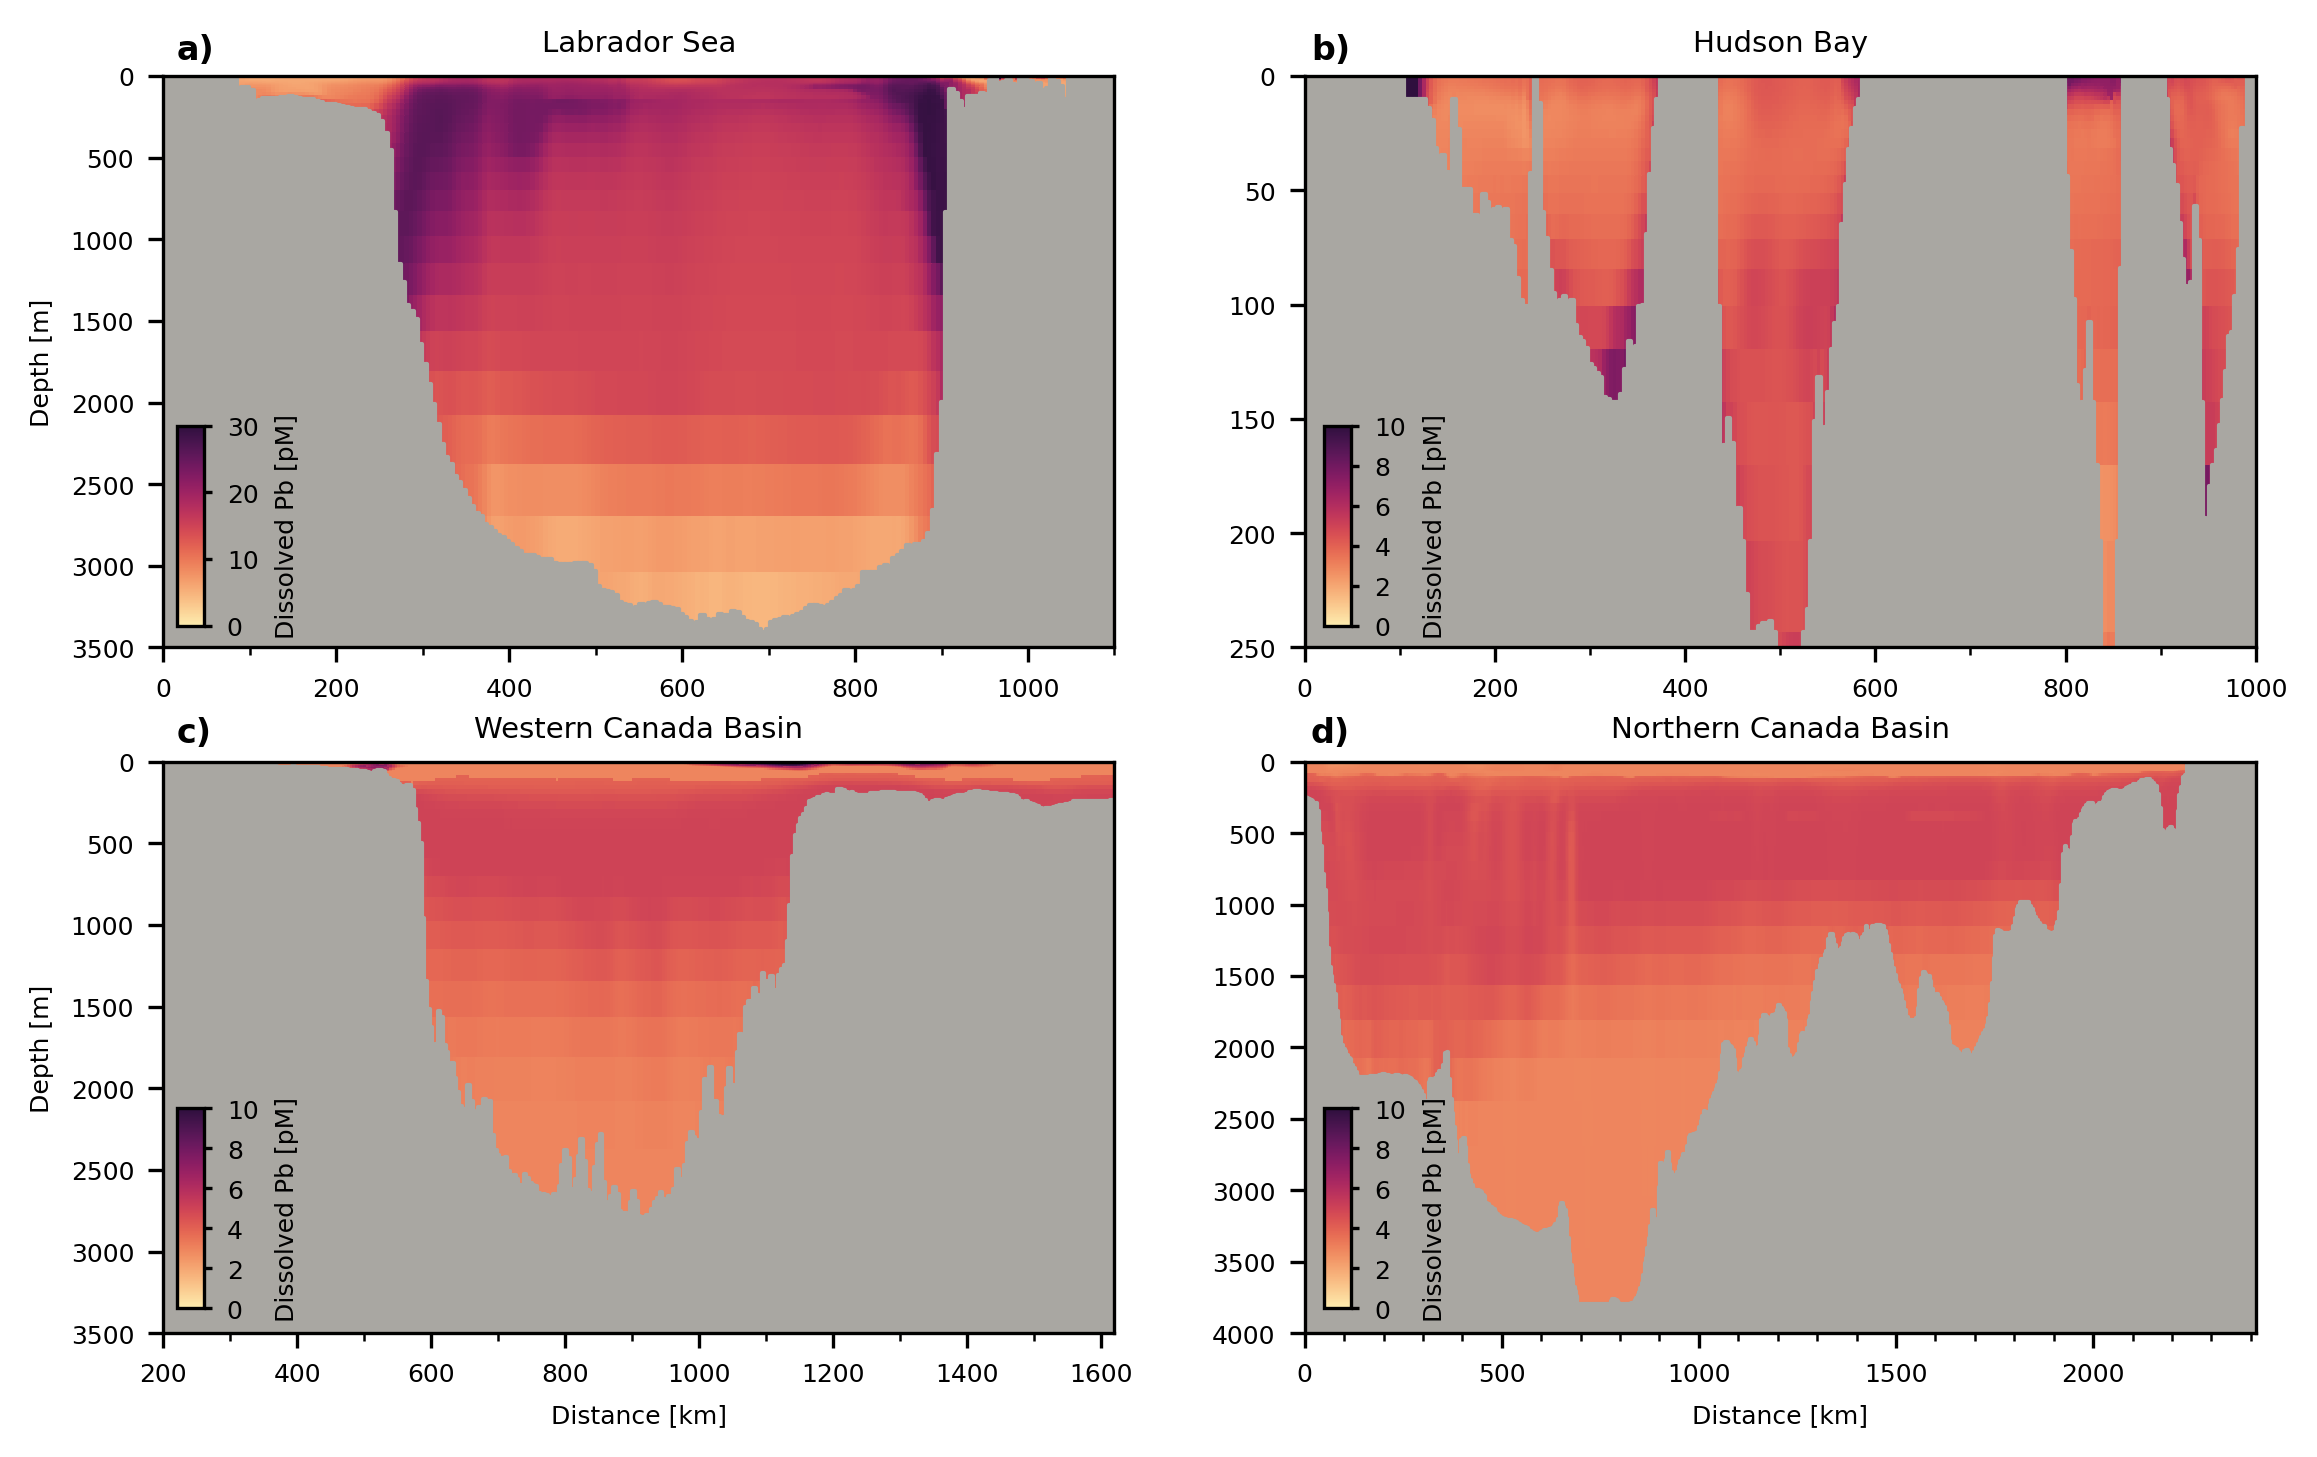

In [131]:
fig, ax = plt.subplots(2,2, figsize=(4.5*2, 3.7*1.5), dpi=300)

ax[0,0].set_title('Labrador Sea', fontsize=7)
ax[0,1].set_title('Hudson Bay', fontsize=7)
ax[1,0].set_title('Western Canada Basin', fontsize=7)
ax[1,1].set_title('Northern Canada Basin', fontsize=7)

ax[1,0].set_xlabel('Distance [km]', fontsize=6)
ax[1,1].set_xlabel('Distance [km]', fontsize=6)
ax[0,0].set_ylabel('Depth [m]', fontsize=6)
ax[1,0].set_ylabel('Depth [m]', fontsize=6)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.xaxis.set_minor_locator(MultipleLocator(100))

ax[0,0].set_xlim(0,1100)    
ax[0,0].set_ylim(3500,0)
ax[0,1].set_ylim(250,0)
ax[1,0].set_ylim(3500,0)
ax[1,1].set_ylim(4000,0)
ax[0,1].set_xlim(0,1000)
ax[1,0].set_xlim(200,1620)
    
cmap = cmocean.cm.matter

# Labrador Sea:
xx, zz = np.meshgrid(S_distance, gdepw1d)
CB1 = ax[0,0].pcolormesh(xx, zz, dPb_S[:,bdy_cell,:]*1e12, vmin=0, vmax=30, cmap=cmap)
ax[0,0].add_collection(LS_patch)

# Hudson Bay: 
xx, zz = np.meshgrid(W_distance, gdepw1d)
CB2 = ax[0,1].pcolormesh(xx, zz, dPb_W[:,:,bdy_cell]*1e12, vmin=0, vmax=10, cmap=cmap)
ax[0,1].add_collection(W_patch)

# Western Canada Basin:
xx, zz = np.meshgrid(N_distance, gdepw1d)
CB3 = ax[1,0].pcolormesh(xx, zz, dPb_N[:,bdy_cell,:]*1e12, vmin=0, vmax=10, cmap=cmap)
ax[1,0].add_collection(N_patch)

# Northern Canada Basin:
xx, zz = np.meshgrid(E_distance[::-1], gdepw1d)
CB4 = ax[1,1].pcolormesh(xx, zz, dPb_E[:,:,-bdy_cell]*1e12, vmin=0, vmax=10, cmap=cmap)
ax[1,1].add_collection(E_patch)

# add text labels:
fig.text(0.13, 0.89, 'a)', fontsize=8, weight='bold');
fig.text(0.55, 0.89, 'b)', fontsize=8, weight='bold');
fig.text(0.13, 0.48, 'c)', fontsize=8, weight='bold');
fig.text(0.55, 0.48, 'd)', fontsize=8, weight='bold');

cbax1 = fig.add_axes([0.13 , 0.55, 0.01, 0.12]);
cbax2 = fig.add_axes([0.555, 0.55, 0.01, 0.12]);
cbax3 = fig.add_axes([0.13 , 0.14, 0.01, 0.12]);
cbax4 = fig.add_axes([0.555, 0.14, 0.01, 0.12]);
cbaxes = [cbax1, cbax2, cbax3, cbax4]

for n,cb in enumerate([CB1, CB2, CB3, CB4]):
    if n > 0:
        CBar = plt.colorbar(cb, ax=ax, cax=cbaxes[n], ticks=[0,2,4,6,8,10]); 
    else:
        CBar = plt.colorbar(cb, ax=ax, cax=cbaxes[n]); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=6)
    CBar.ax.tick_params(axis='y', length=2, width=0.8, labelsize=6)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/M2-transect-boundary.jpg', dpi=300, bbox_inches='tight')